### <font color=deeppink> Importing libraries </font>

In [1]:
import shutil, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools


%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### <font color=deeppink> Making Dictionary  </font>

In [2]:
dir = '../input/skin-cancer-mnist-ham10000/'
os.listdir(dir)

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

In [3]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

In [4]:
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

In [5]:
# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

In [6]:
# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [7]:
df_data = pd.read_csv(dir+'HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### <font color=deeppink> Data Cleaning</font>

In [8]:
# grouping all images and counting them by each lesion_id
df = df_data.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [9]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [10]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [11]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [12]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [13]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

In [14]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [15]:
print("Training data\n",df_train['dx'].value_counts())
print("Validating data\n",df_val['dx'].value_counts())

Training data
 nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64
Validating data
 nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64


### <font color=deeppink> Transfering the Images into the Folders</font>

In [16]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [17]:
base_dir = 'base_dir'

train_dir = os.path.join(base_dir, 'train_dir')

val_dir = os.path.join(base_dir, 'val_dir')

In [18]:
# Get a list of images in each of the two folders
folder_1 = os.listdir(dir+'ham10000_images_part_1')
folder_2 = os.listdir(dir+'ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(dir+'ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(dir+'ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(dir+'ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(dir+'ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        

In [19]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [20]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


In [21]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [22]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 9077 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


# <font color=deeppink>  MobileNet </font>

In [23]:
mobile = tf.keras.applications.mobilenet.MobileNet()

2023-02-03 10:14:37.466039: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


17235968/17225924 [==============================] - 0s 0us/step


In [24]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [25]:
#layers in mobile net
len(mobile.layers)

92

In [26]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(x)
# # Create a new dense layer for predictions
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# 7 corresponds to the number of classes
x = tf.keras.layers.Dropout(0.25)(x)
predictions = tf.keras.layers.Dense(7, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = tf.keras.Model(inputs=mobile.input, outputs=predictions)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [28]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 25 layers in the new model.
# The last 25 layers of the model will be trained.

for layer in model.layers[:-25]:
    layer.trainable = False

# model.trainable = False # We don't want to re-train the pre-trained weights

In [29]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [30]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [31]:
train = model.fit(train_batches, steps_per_epoch=train_steps, 

                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=5, verbose=1)

2023-02-03 10:14:38.788082: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
908/908 [==============================] - 249s 272ms/step - loss: 0.9757 - accuracy: 0.6644 - val_loss: 0.4722 - val_accuracy: 0.8507
Epoch 2/5
908/908 [==============================] - 248s 272ms/step - loss: 0.7727 - accuracy: 0.7256 - val_loss: 0.4025 - val_accuracy: 0.8657
Epoch 3/5
908/908 [==============================] - 245s 269ms/step - loss: 0.6970 - accuracy: 0.7516 - val_loss: 0.3693 - val_accuracy: 0.8774
Epoch 4/5
908/908 [==============================] - 244s 268ms/step - loss: 0.6274 - accuracy: 0.7755 - val_loss: 0.3658 - val_accuracy: 0.8817
Epoch 5/5
908/908 [==============================] - 244s 268ms/step - loss: 0.5790 - accuracy: 0.7916 - val_loss: 0.3440 - val_accuracy: 0.8913


Evaluate the model using the val set

In [32]:
model.metrics_names

['loss', 'accuracy']

In [33]:
val_loss, val_acc = model.evaluate(test_batches, steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

938/938 [==============================] - 25s 26ms/step - loss: 0.3440 - accuracy: 0.8913
val_loss: 0.3439837396144867
val_acc: 0.8912580013275146


In [34]:
loss, accuracy = model.evaluate(test_batches)
loss_v, accuracy_v = model.evaluate(valid_batches,steps=len(df_val))
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

938/938 [==============================] - 18s 19ms/step - loss: 0.3440 - accuracy: 0.8913
Validation: accuracy = 0.891258  ;  loss_v = 0.343983
Test: accuracy = 0.891258  ;  loss = 0.343984


### Plotting graph training vs validation

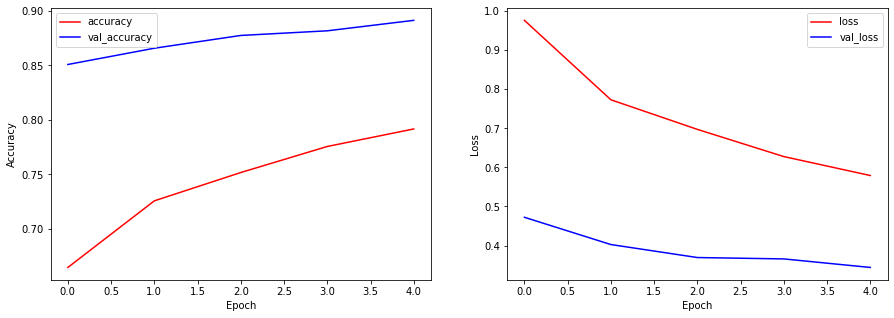

In [35]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],'r', label='accuracy')
plt.plot(train.history['val_accuracy'],'b', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# plt.show()
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],'r', label='loss')
plt.plot(train.history['val_loss'],'b', label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
test_labels = test_batches.classes
# print(test_labels)
print(test_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [37]:
# make a prediction
predictions = model.predict(test_batches, steps=len(df_val), verbose=1)

938/938 [==============================] - 25s 26ms/step


In [38]:
print(predictions.shape,"\n",test_labels.shape)

(938, 7) 
 (938,)


In [39]:
def plot_confusion_matrix(cm, classes,title,
                          normalize=False,cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[  9   5   6   0   2   4   0]
 [  1  26   2   0   0   1   0]
 [  1   4  45   0   8  17   0]
 [  0   0   1   1   0   4   0]
 [  0   1   7   0  18  13   0]
 [  4   9   3   0   5 730   0]
 [  0   0   0   0   0   4   7]]


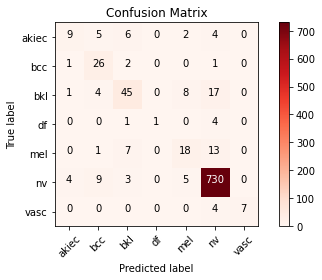

In [40]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

Test image shape:  (1, 224, 224, 3)
predictions:  [[0.10770775 0.13162284 0.28075802 0.00695971 0.28496453 0.18745722
  0.00052997]]
 lesions type: 4


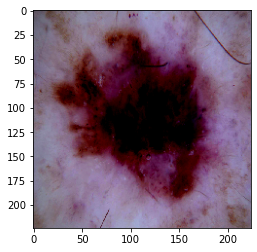

In [41]:
# test_batches
test_img = test_batches[2][0]
print("Test image shape: ",test_img.shape)
predictions= model.predict(test_img)
print("predictions: ",predictions)
def max_ypred(y_pred):
    max_ypred2 = np.max(predictions)
    for i,n in enumerate(predictions[0]):
        if n == max_ypred2:
            return i

print(' lesions type: {}'.format(max_ypred(predictions)))
plt.imshow(test_img.reshape(224,224,3))